# Deepfake Image detection using ViT

Project by:  
[Jen Patrick Nataba](https://ph.linkedin.com/in/cytojen)  
[John Ferry Lagman](https://ph.linkedin.com/in/thatjohnlagman)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install evaluate transformers datasets accelerate

# Importing

In [ ]:
import gc
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from imblearn.over_sampling import RandomOverSampler
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    )
import torch
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomRotation,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pathlib import Path

# loading and preprocessing

In [ ]:
def load_and_preprocess_data(data_path):
    file_names = []
    labels = []
    for file in sorted((Path(data_path).glob('*/*/*.*'))):
        label = str(file).split('/')[-2]
        labels.append(label)
        file_names.append(str(file))

    df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

    y = df[['label']]
    df = df.drop(['label'], axis=1)
    ros = RandomOverSampler(random_state=83)
    df, y_resampled = ros.fit_resample(df, y)
    del y
    df['label'] = y_resampled
    del y_resampled
    gc.collect()

    dataset = Dataset.from_pandas(df).cast_column("image", Image())

    labels_list = ['Real', 'Fake']
    label2id, id2label = dict(), dict()
    for i, label in enumerate(labels_list):
        label2id[label] = i
        id2label[i] = label

    ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

    def map_label2id(example):
        example['label'] = ClassLabels.str2int(example['label'])
        return example

    dataset = dataset.map(map_label2id, batched=True)
    dataset = dataset.cast_column('label', ClassLabels)
    dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")
    train_data = dataset['train']
    test_data = dataset['test']

    return train_data, test_data, labels_list, id2label, label2id

In [ ]:
def define_transforms(image_mean, image_std, size):
    normalize = Normalize(mean=image_mean, std=image_std)
    _train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(90),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize
        ]
    )
    _val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize
        ]
    )

    def train_transforms(examples):
        examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
        return examples

    def val_transforms(examples):
        examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
        return examples

    return train_transforms, val_transforms

In [ ]:
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {
        "accuracy": acc_score
    }


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# training then model

In [ ]:
def train_and_evaluate(data_path, model_name="google/vit-base-patch16-224-in21k", num_train_epochs=2):
    train_data, test_data, labels_list, id2label, label2id = load_and_preprocess_data(data_path)

    processor = ViTImageProcessor.from_pretrained(model_name)
    image_mean, image_std = processor.image_mean, processor.image_std
    size = processor.size["height"]

    # image transformations
    train_transforms, val_transforms = define_transforms(image_mean, image_std, size)
    train_data.set_transform(train_transforms)
    test_data.set_transform(val_transforms)

    def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        labels = torch.tensor([example['label'] for example in examples])
        return {"pixel_values": pixel_values, "labels": labels}

    # ViT model
    model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(labels_list))
    model.config.id2label = id2label
    model.config.label2id = label2id

    accuracy = evaluate.load("accuracy")

    def compute_metrics(eval_pred, accuracy):
        predictions = eval_pred.predictions
        label_ids = eval_pred.label_ids
        predicted_labels = predictions.argmax(axis=1)
        acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
        return {
            "accuracy": acc_score
        }

    args = TrainingArguments(
        output_dir="/content/drive/MyDrive/omdena_hackathon/models/deepfake_image_detector",
        logging_dir='/content/drive/MyDrive/omdena_hackathon/logs',
        evaluation_strategy="epoch",
        learning_rate=1e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=16,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        warmup_steps=50,
        remove_unused_columns=False,
        save_strategy='epoch',
        load_best_model_at_end=True,
        save_total_limit=1,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_data,
        eval_dataset=test_data,
        data_collator=collate_fn,
        compute_metrics=lambda eval_pred: compute_metrics(eval_pred, accuracy),
        tokenizer=processor,
    )

    trainer.evaluate()

    trainer.train()

    trainer.evaluate()

    outputs = trainer.predict(test_data)
    print(outputs.metrics)

    # eval metrics

    y_true = outputs.label_ids
    y_pred = outputs.predictions.argmax(1)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")

    if len(labels_list) <= 150:
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

    trainer.save_model()


Map:   0%|          | 0/190402 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190402 [00:00<?, ? examples/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.110400,0.097075,0.965586
2,0.075700,0.089813,0.968724


{'test_loss': 0.08981271088123322, 'test_accuracy': 0.9687241501555914, 'test_runtime': 756.472, 'test_samples_per_second': 100.679, 'test_steps_per_second': 3.148}
Accuracy: 0.9687
F1 Score: 0.9687


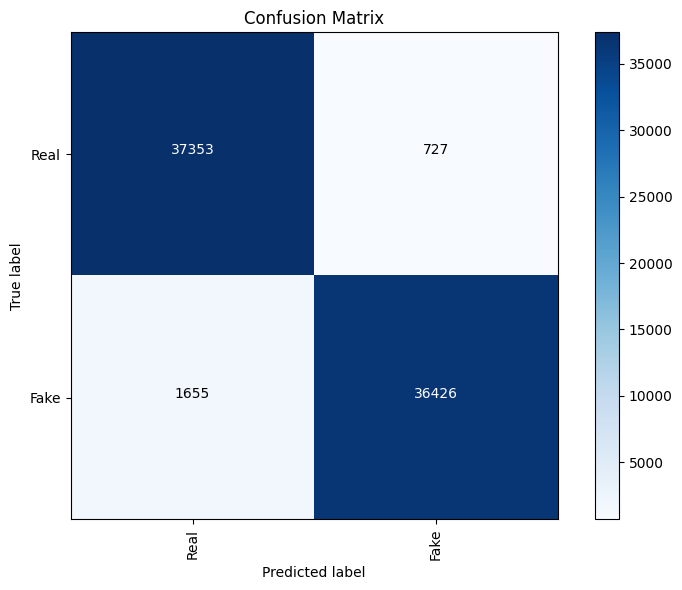


Classification report:

              precision    recall  f1-score   support

        Real     0.9576    0.9809    0.9691     38080
        Fake     0.9804    0.9565    0.9683     38081

    accuracy                         0.9687     76161
   macro avg     0.9690    0.9687    0.9687     76161
weighted avg     0.9690    0.9687    0.9687     76161



In [ ]:
data_path = '/content/drive/MyDrive/omdena_hackathon/datasets/deepfake_image'
train_and_evaluate(data_path)

# thoughts

Training this image classification model with ViT was definitely a challenge, but it’s turning out to be really effective. We used oversampling to deal with imbalanced datasets, and some pretty cool image transformations to make the model more solid. But yea, there were hiccups, like running out of resources and the occasional crashes since this project was really just a passion project and developing this on a tight setup + academic worries wasn’t easy. In the end, it might not be perfect, but it’s a project we worked hard on.